<a href="https://colab.research.google.com/github/Asfilcnx3/Project5_MNIST/blob/main/MNIST_Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the MNIST dataset to computer vision
* We will use "dataloader" to use less RAM

In [1]:
# Load the librarys
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Estas usando: {device}")

Estas usando: cuda


----------------------------------------
El número de la imagen es:        7
----------------------------------------


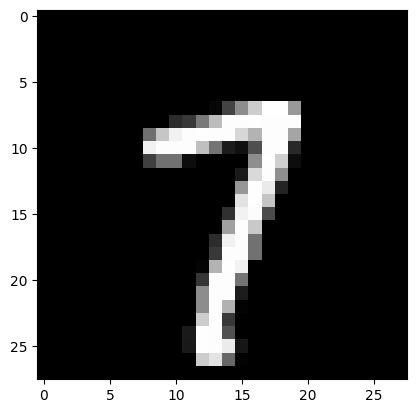

In [2]:
# Load the data from datasets
transform = transforms.ToTensor()
data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Visualize the data
index = 96 # <- Thats the index (change if you want to see a different number)

# Load on DataFrame
df = pd.DataFrame(data.data.numpy().reshape(-1, 28*28))
y = data.targets.numpy()
print("----" * 10)
print(f"El número de la imagen es:        {y[index]}")
print("----" * 10)
plt.imshow(df.iloc[index, :].values.reshape(28, 28), cmap = "binary_r")
plt.show()

In [3]:
# Split the dataset manually
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

# Using Batch_Size to load data in a light way (using less ram)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Tamaño del set de entrenamiento: {len(train_loader.dataset)}")
print(f"Tamaño del set de validación: {len(val_loader.dataset)}")
print(f"Tamaño del set de prueba: {len(test_loader.dataset)}")

Tamaño del set de entrenamiento: 42000
Tamaño del set de validación: 9000
Tamaño del set de prueba: 9000


### Create a Convolutional Neural Network with this arquitecture:
`Conv2D -> MaxPool -> Conv2D -> Maxpool -> Flatten -> Dense -> Dense`
* CrossEntropyLoss y Adam

Epoch: 1/10, Train Loss: 0.2572, Val Loss: 0.0892, Val Acc: 97.17%
----------------------------------------
Epoch: 2/10, Train Loss: 0.0689, Val Loss: 0.0814, Val Acc: 97.57%
----------------------------------------
Epoch: 3/10, Train Loss: 0.0471, Val Loss: 0.0618, Val Acc: 98.19%
----------------------------------------
Epoch: 4/10, Train Loss: 0.0355, Val Loss: 0.0551, Val Acc: 98.32%
----------------------------------------
Epoch: 5/10, Train Loss: 0.0290, Val Loss: 0.0494, Val Acc: 98.63%
----------------------------------------
Epoch: 6/10, Train Loss: 0.0236, Val Loss: 0.0474, Val Acc: 98.69%
----------------------------------------
Epoch: 7/10, Train Loss: 0.0190, Val Loss: 0.0506, Val Acc: 98.58%
----------------------------------------
Epoch: 8/10, Train Loss: 0.0160, Val Loss: 0.0520, Val Acc: 98.64%
----------------------------------------
Epoch: 9/10, Train Loss: 0.0126, Val Loss: 0.0672, Val Acc: 98.22%
----------------------------------------
Epoch: 10/10, Train Loss: 0.

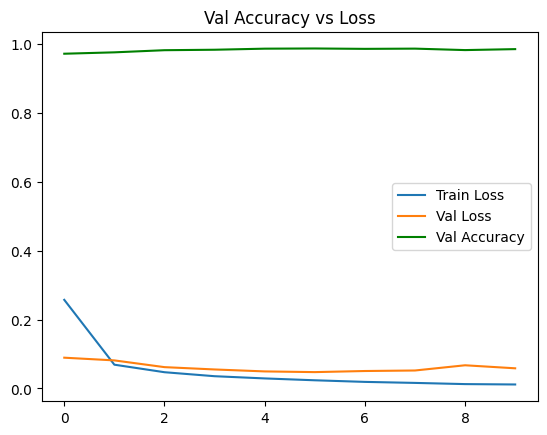

In [4]:
# Creating a CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 1 input chanel (the gray scale)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # padding=1 to keep the size
    self.pool = nn.MaxPool2d(2, 2) # reduce by half the dimensions
    self.flatten = nn.Flatten() # Flatten layer
    self.fc1 = nn.Linear(64* 7 * 7, 64) # The outputs were reduce to 14x14 after to 7x7
    self.out = nn.Linear(64, 10) # 10 final outputs

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    return self.out(x)

# Work the model in the GPU
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

# Create the training loop
epochs = 10
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_losses.append(running_loss / len(train_loader))

  model.eval()
  val_loss = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  acc = accuracy_score(all_labels, all_preds)
  val_losses.append(val_loss / len(val_loader))
  val_accs.append(acc)


  print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")
  print("----" * 10)

# Visalize the loss and accuracy
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accs, label="Val Accuracy", color='green')
plt.title("Val Accuracy vs Loss")
plt.legend()
plt.show()

----------------------------------------
Accuracy: 98.7889%
----------------------------------------


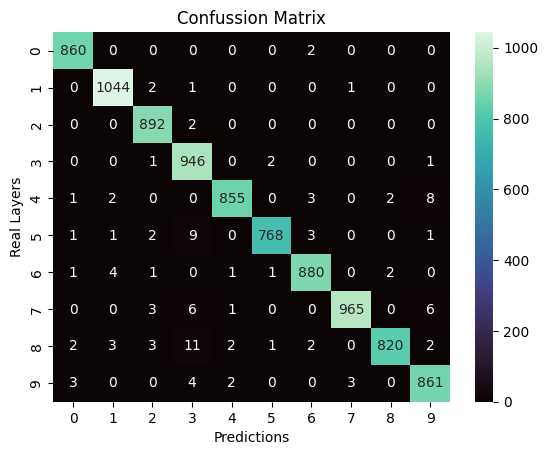

In [5]:
# Evaluando con los el set de prueba
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("----" * 10)
print(f'Accuracy: {acc*100:.4f}%')
print("----" * 10)

# Creamos su matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="mako")
plt.title("Confussion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Layers")
plt.show()